Size for class 1: 6631
Selected size: 331


Size for class 2: 18649
Selected size: 932


Size for class 3: 2099
Selected size: 104


Size for class 4: 3064
Selected size: 153


Size for class 5: 1345
Selected size: 67


Size for class 6: 5029
Selected size: 251


Size for class 7: 1330
Selected size: 66


Size for class 8: 3682
Selected size: 184


Size for class 9: 947
Selected size: 47


Test size:  (40641, 103)
Train size:  (2135, 103)
Train frac:  4.991116513933046
vig  tr:  (2135, 90)
vig  test:  (40641, 90)
Size for class 1: 6631
Selected size: 331


Size for class 2: 18649
Selected size: 932


Size for class 3: 2099
Selected size: 104


Size for class 4: 3064
Selected size: 153


Size for class 5: 1345
Selected size: 67


Size for class 6: 5029
Selected size: 251


Size for class 7: 1330
Selected size: 66


Size for class 8: 3682
Selected size: 184


Size for class 9: 947
Selected size: 47


Test size:  (40641, 103)
Train size:  (2135, 103)
Train frac:  4.991116513933046
vig  tr

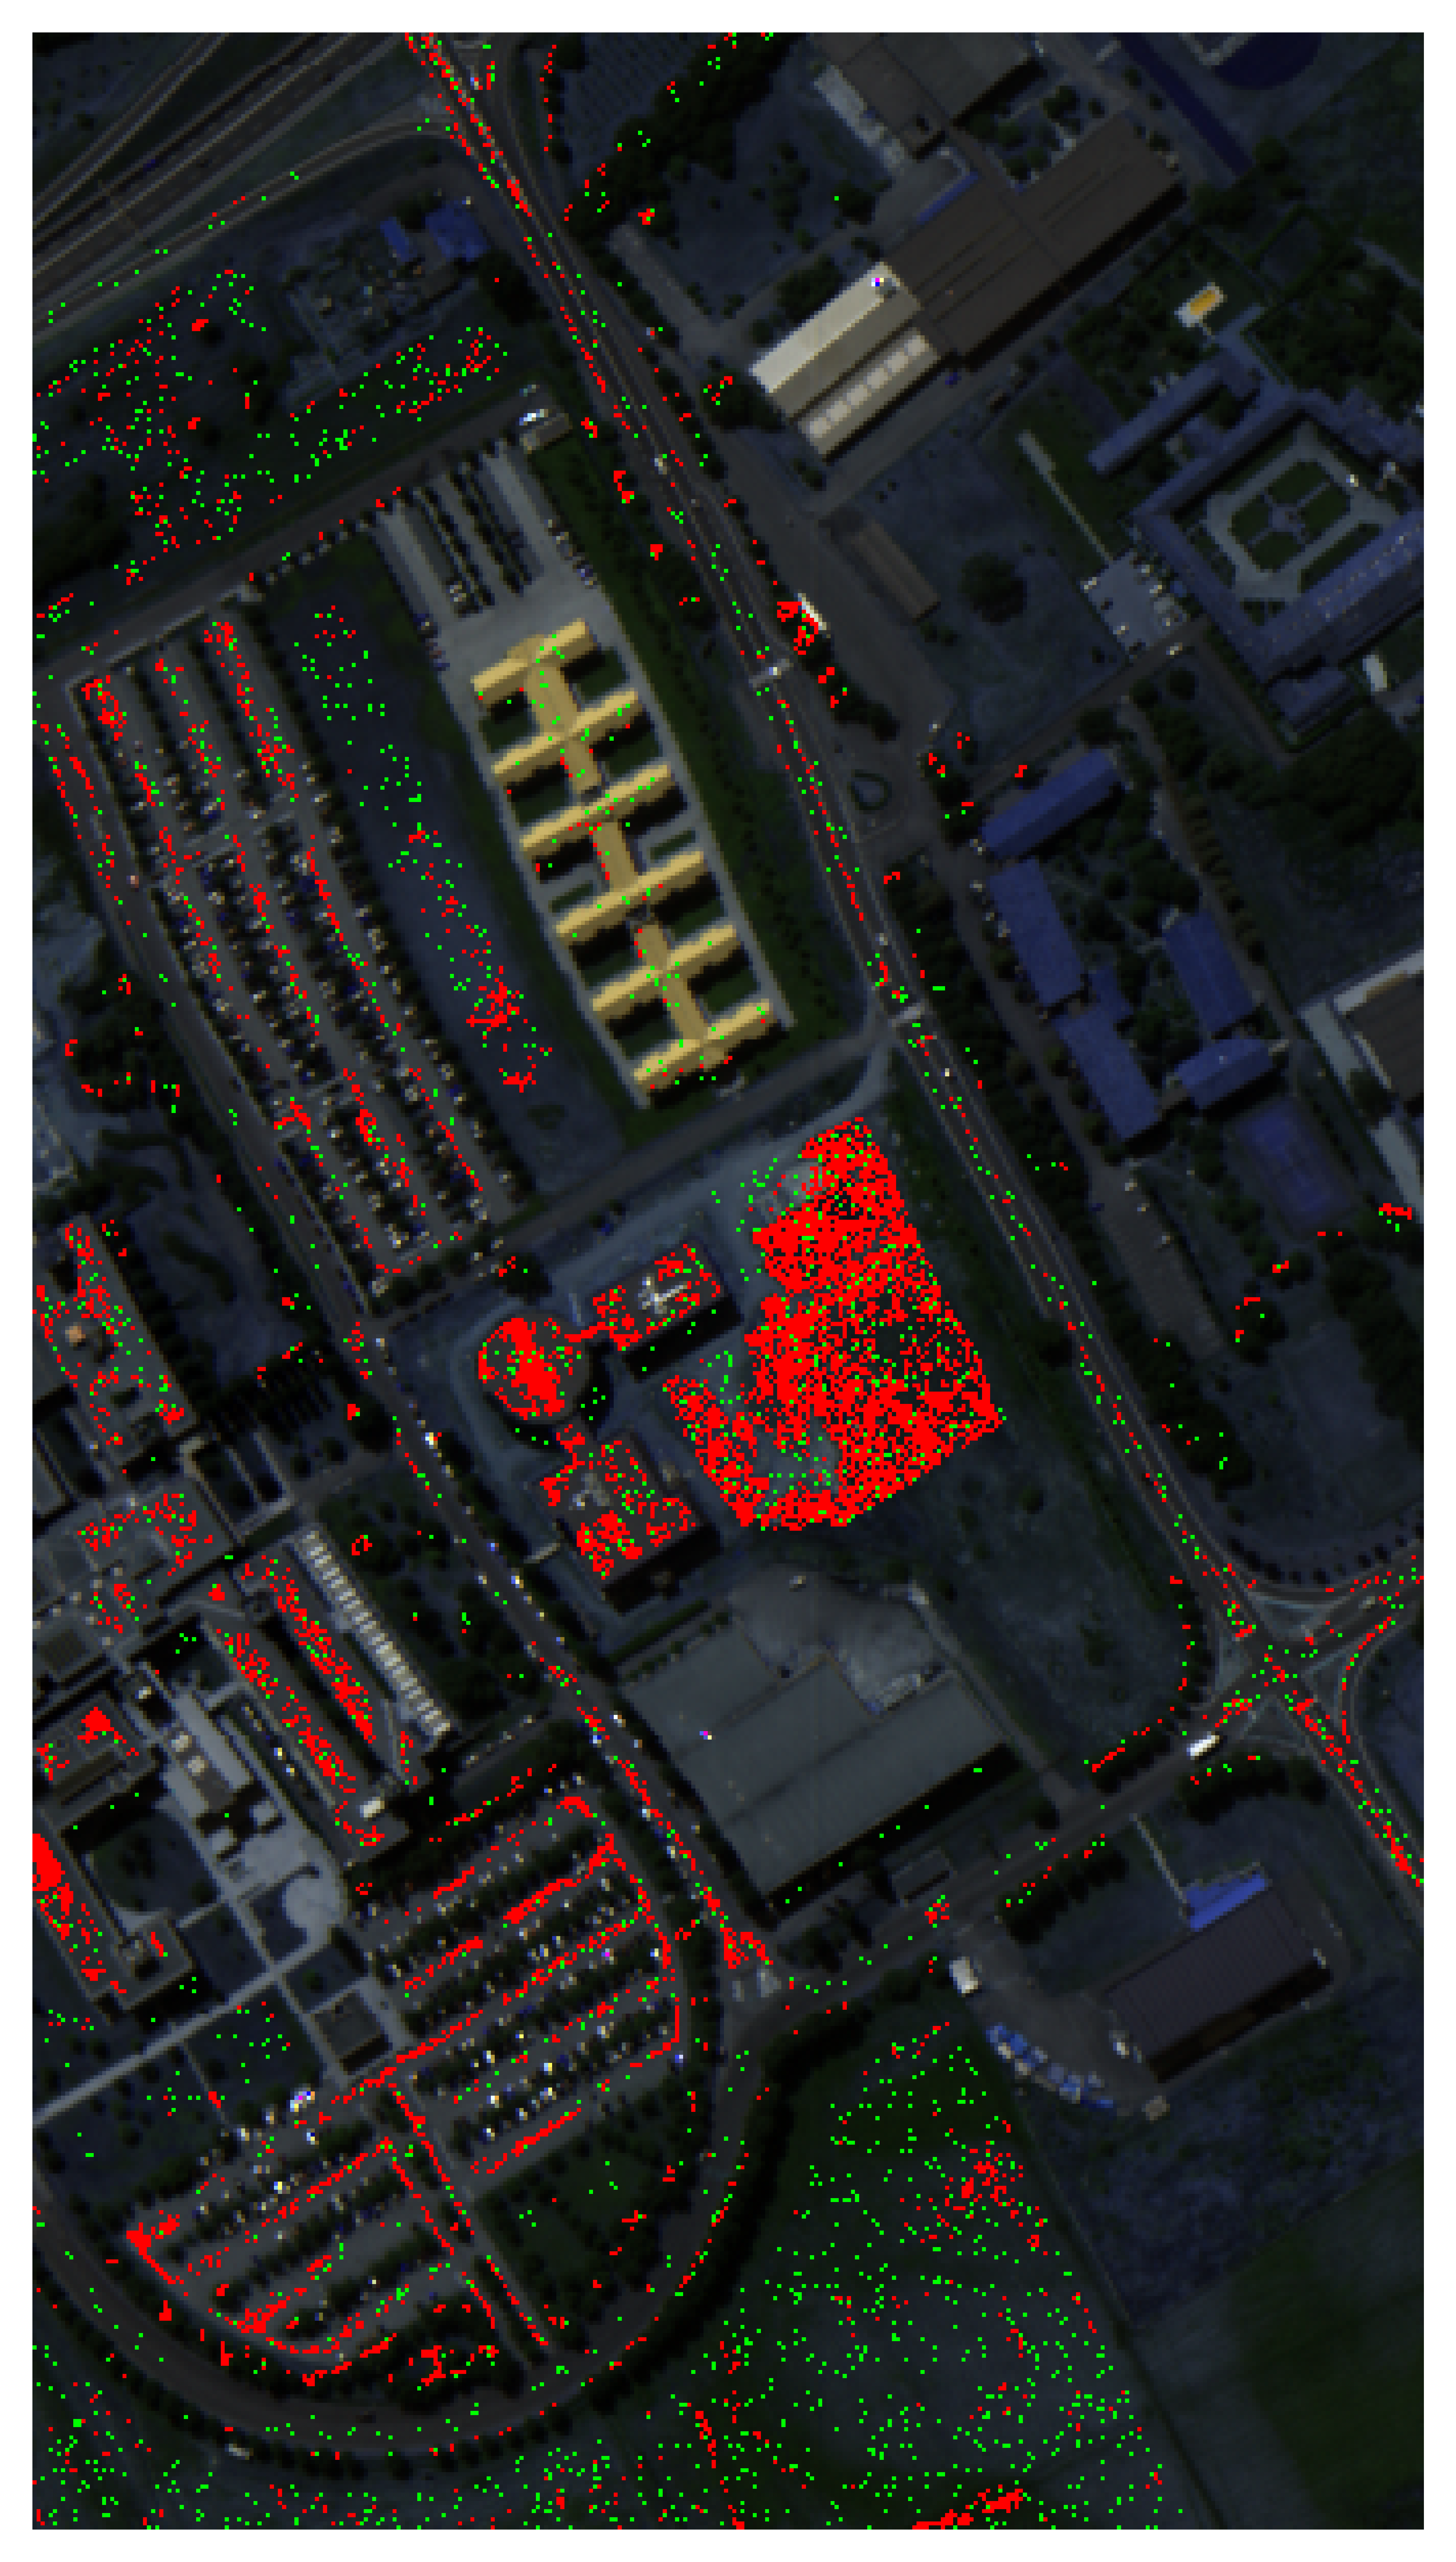

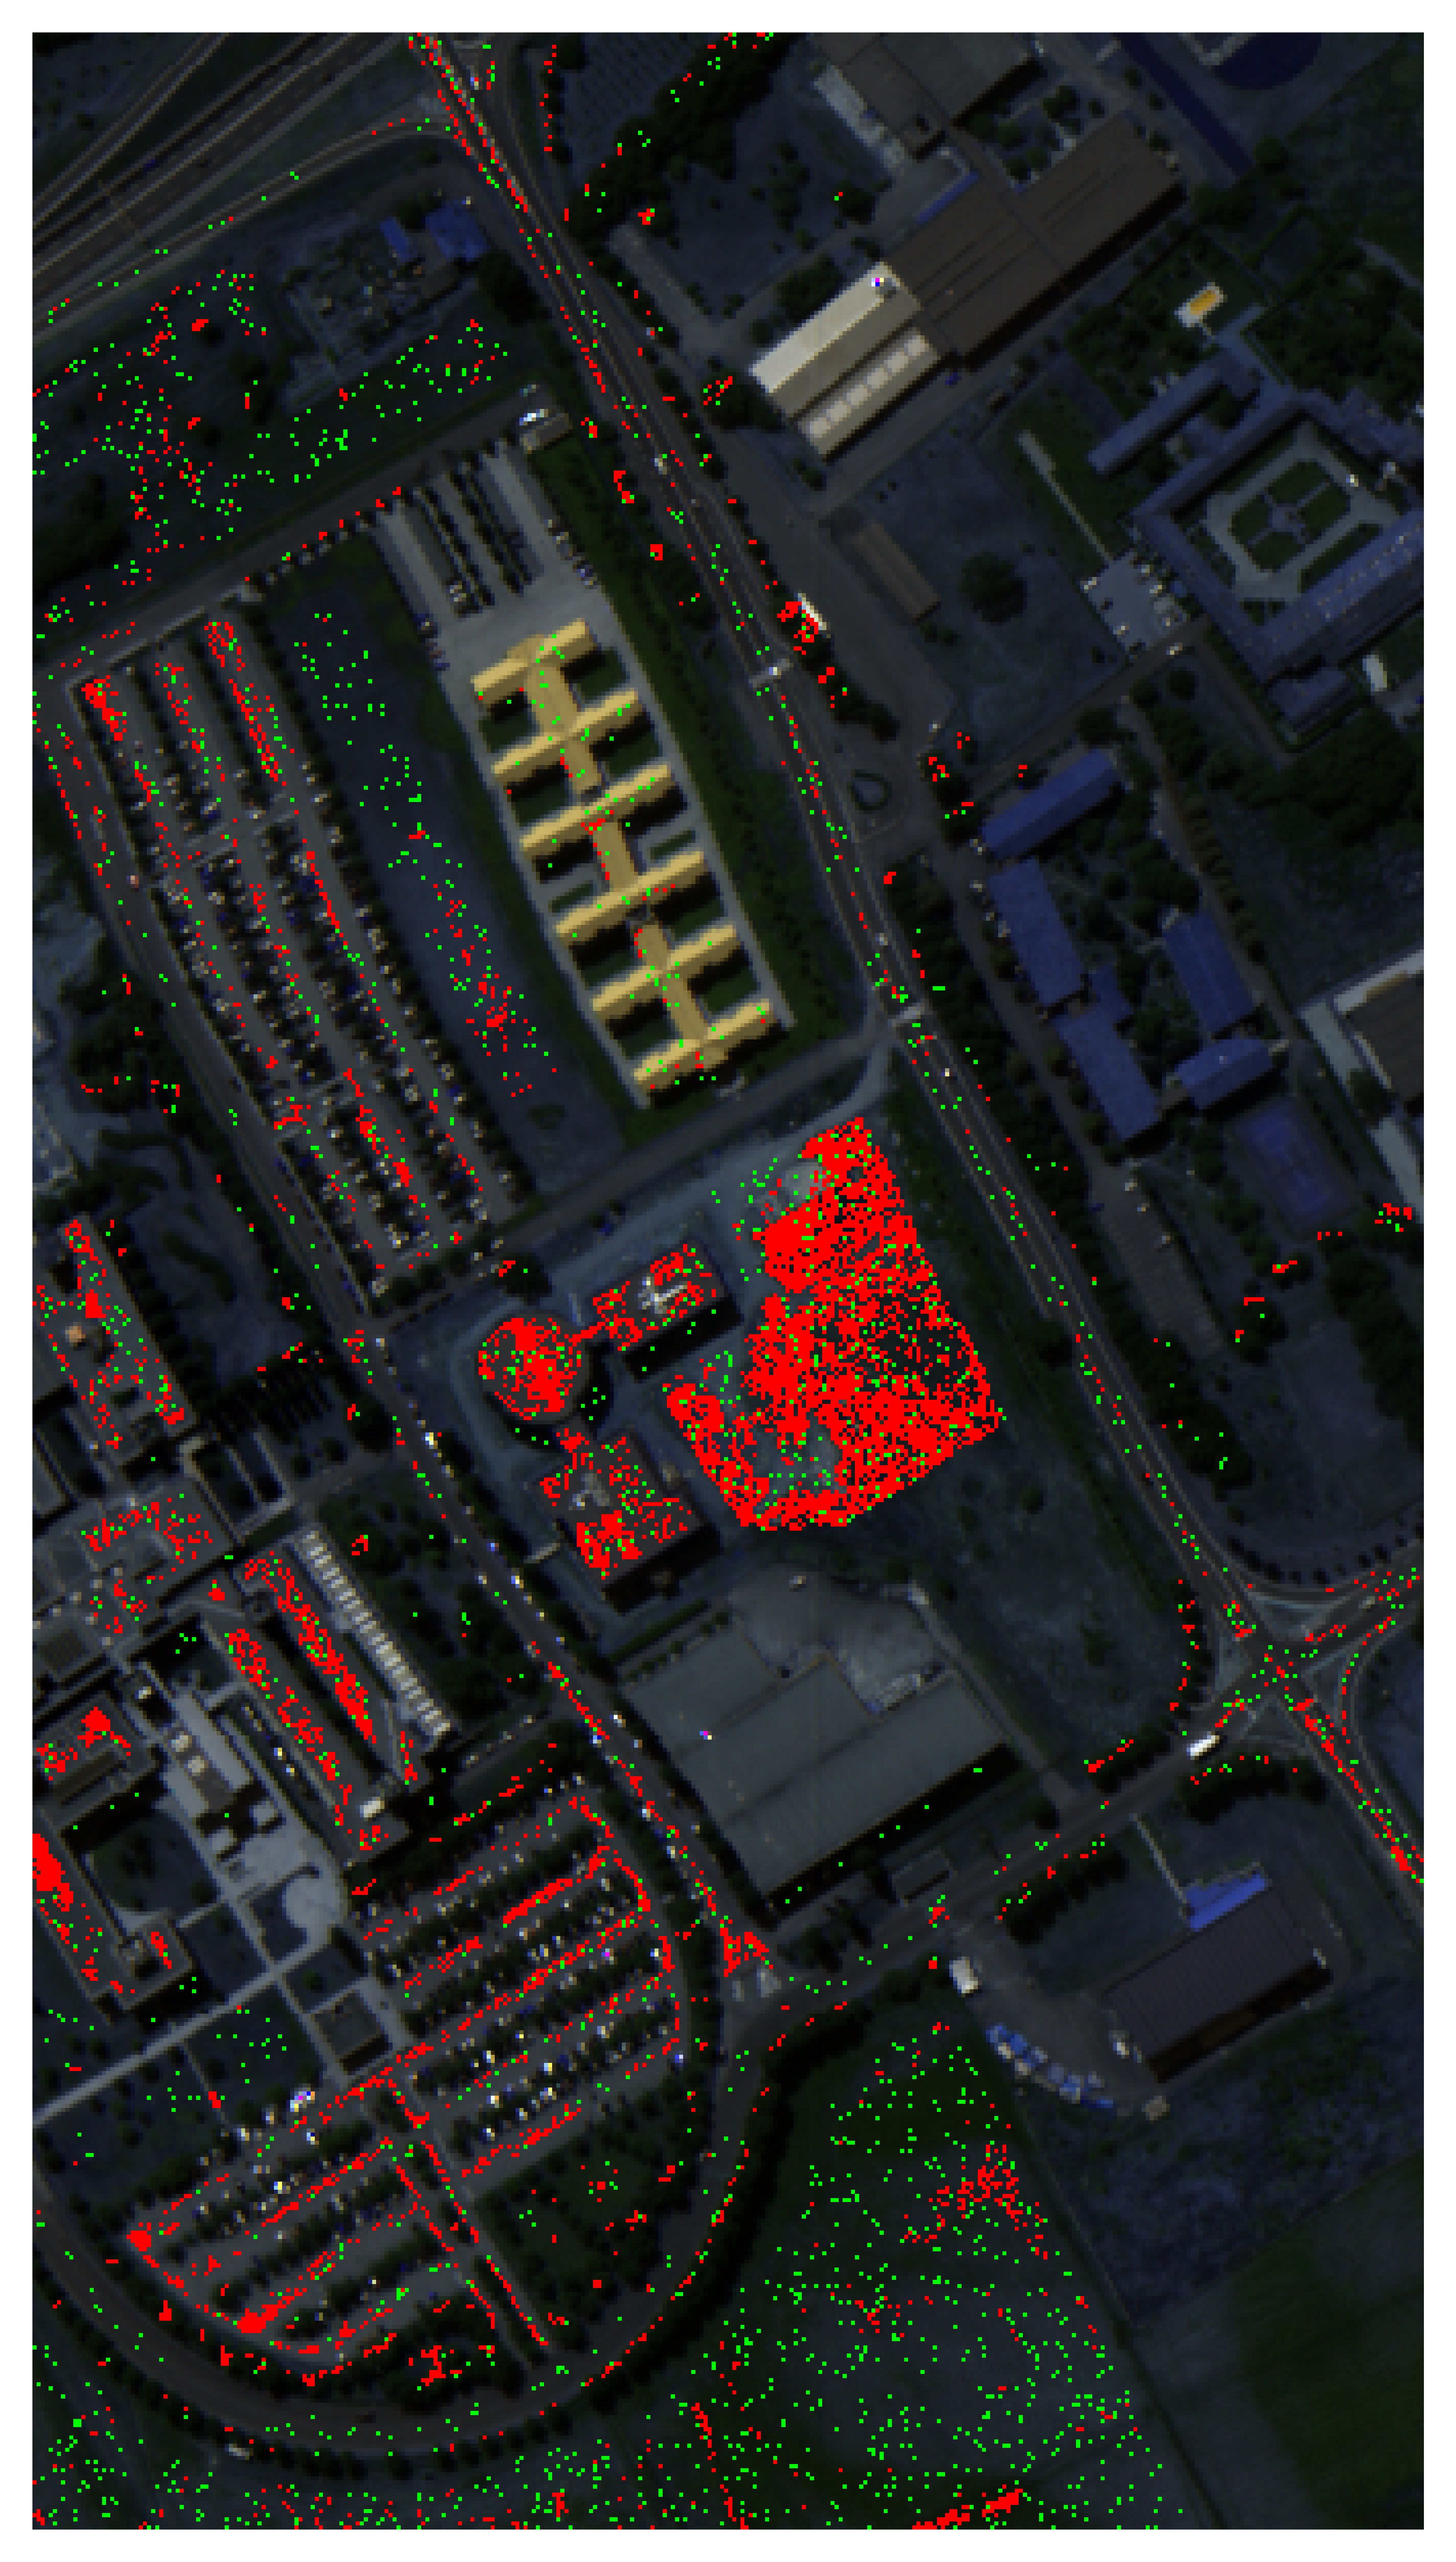

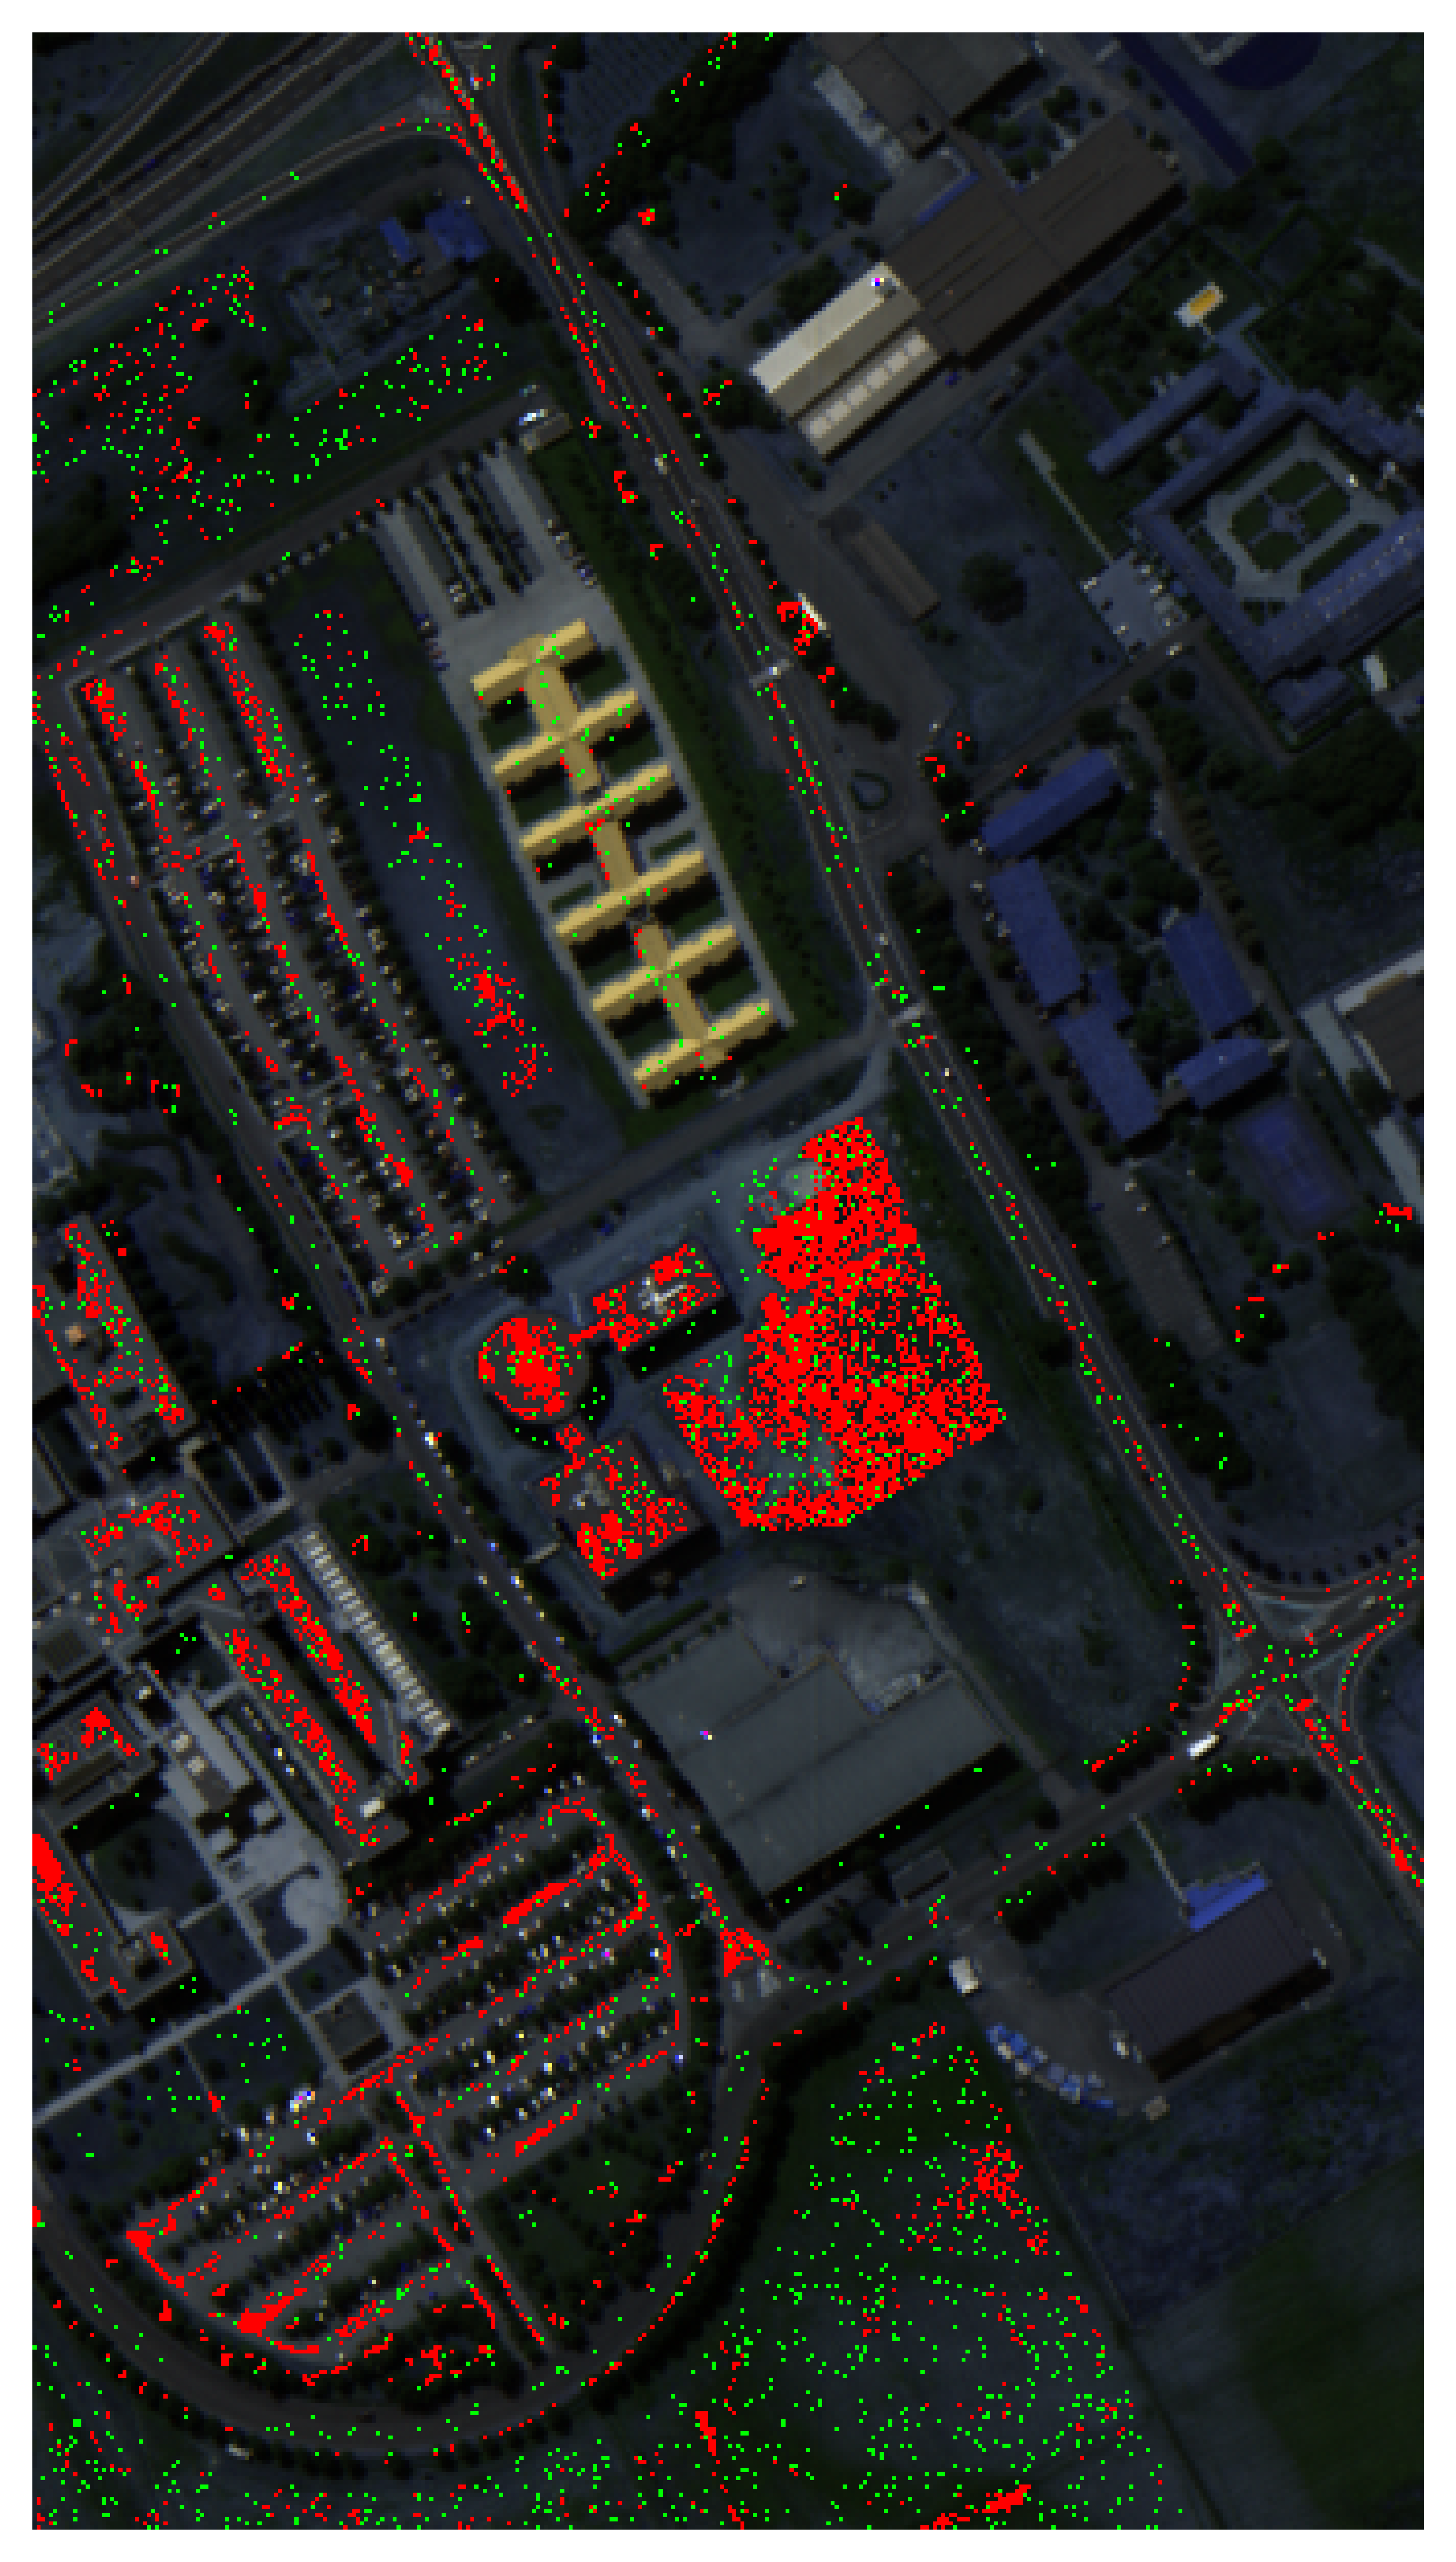

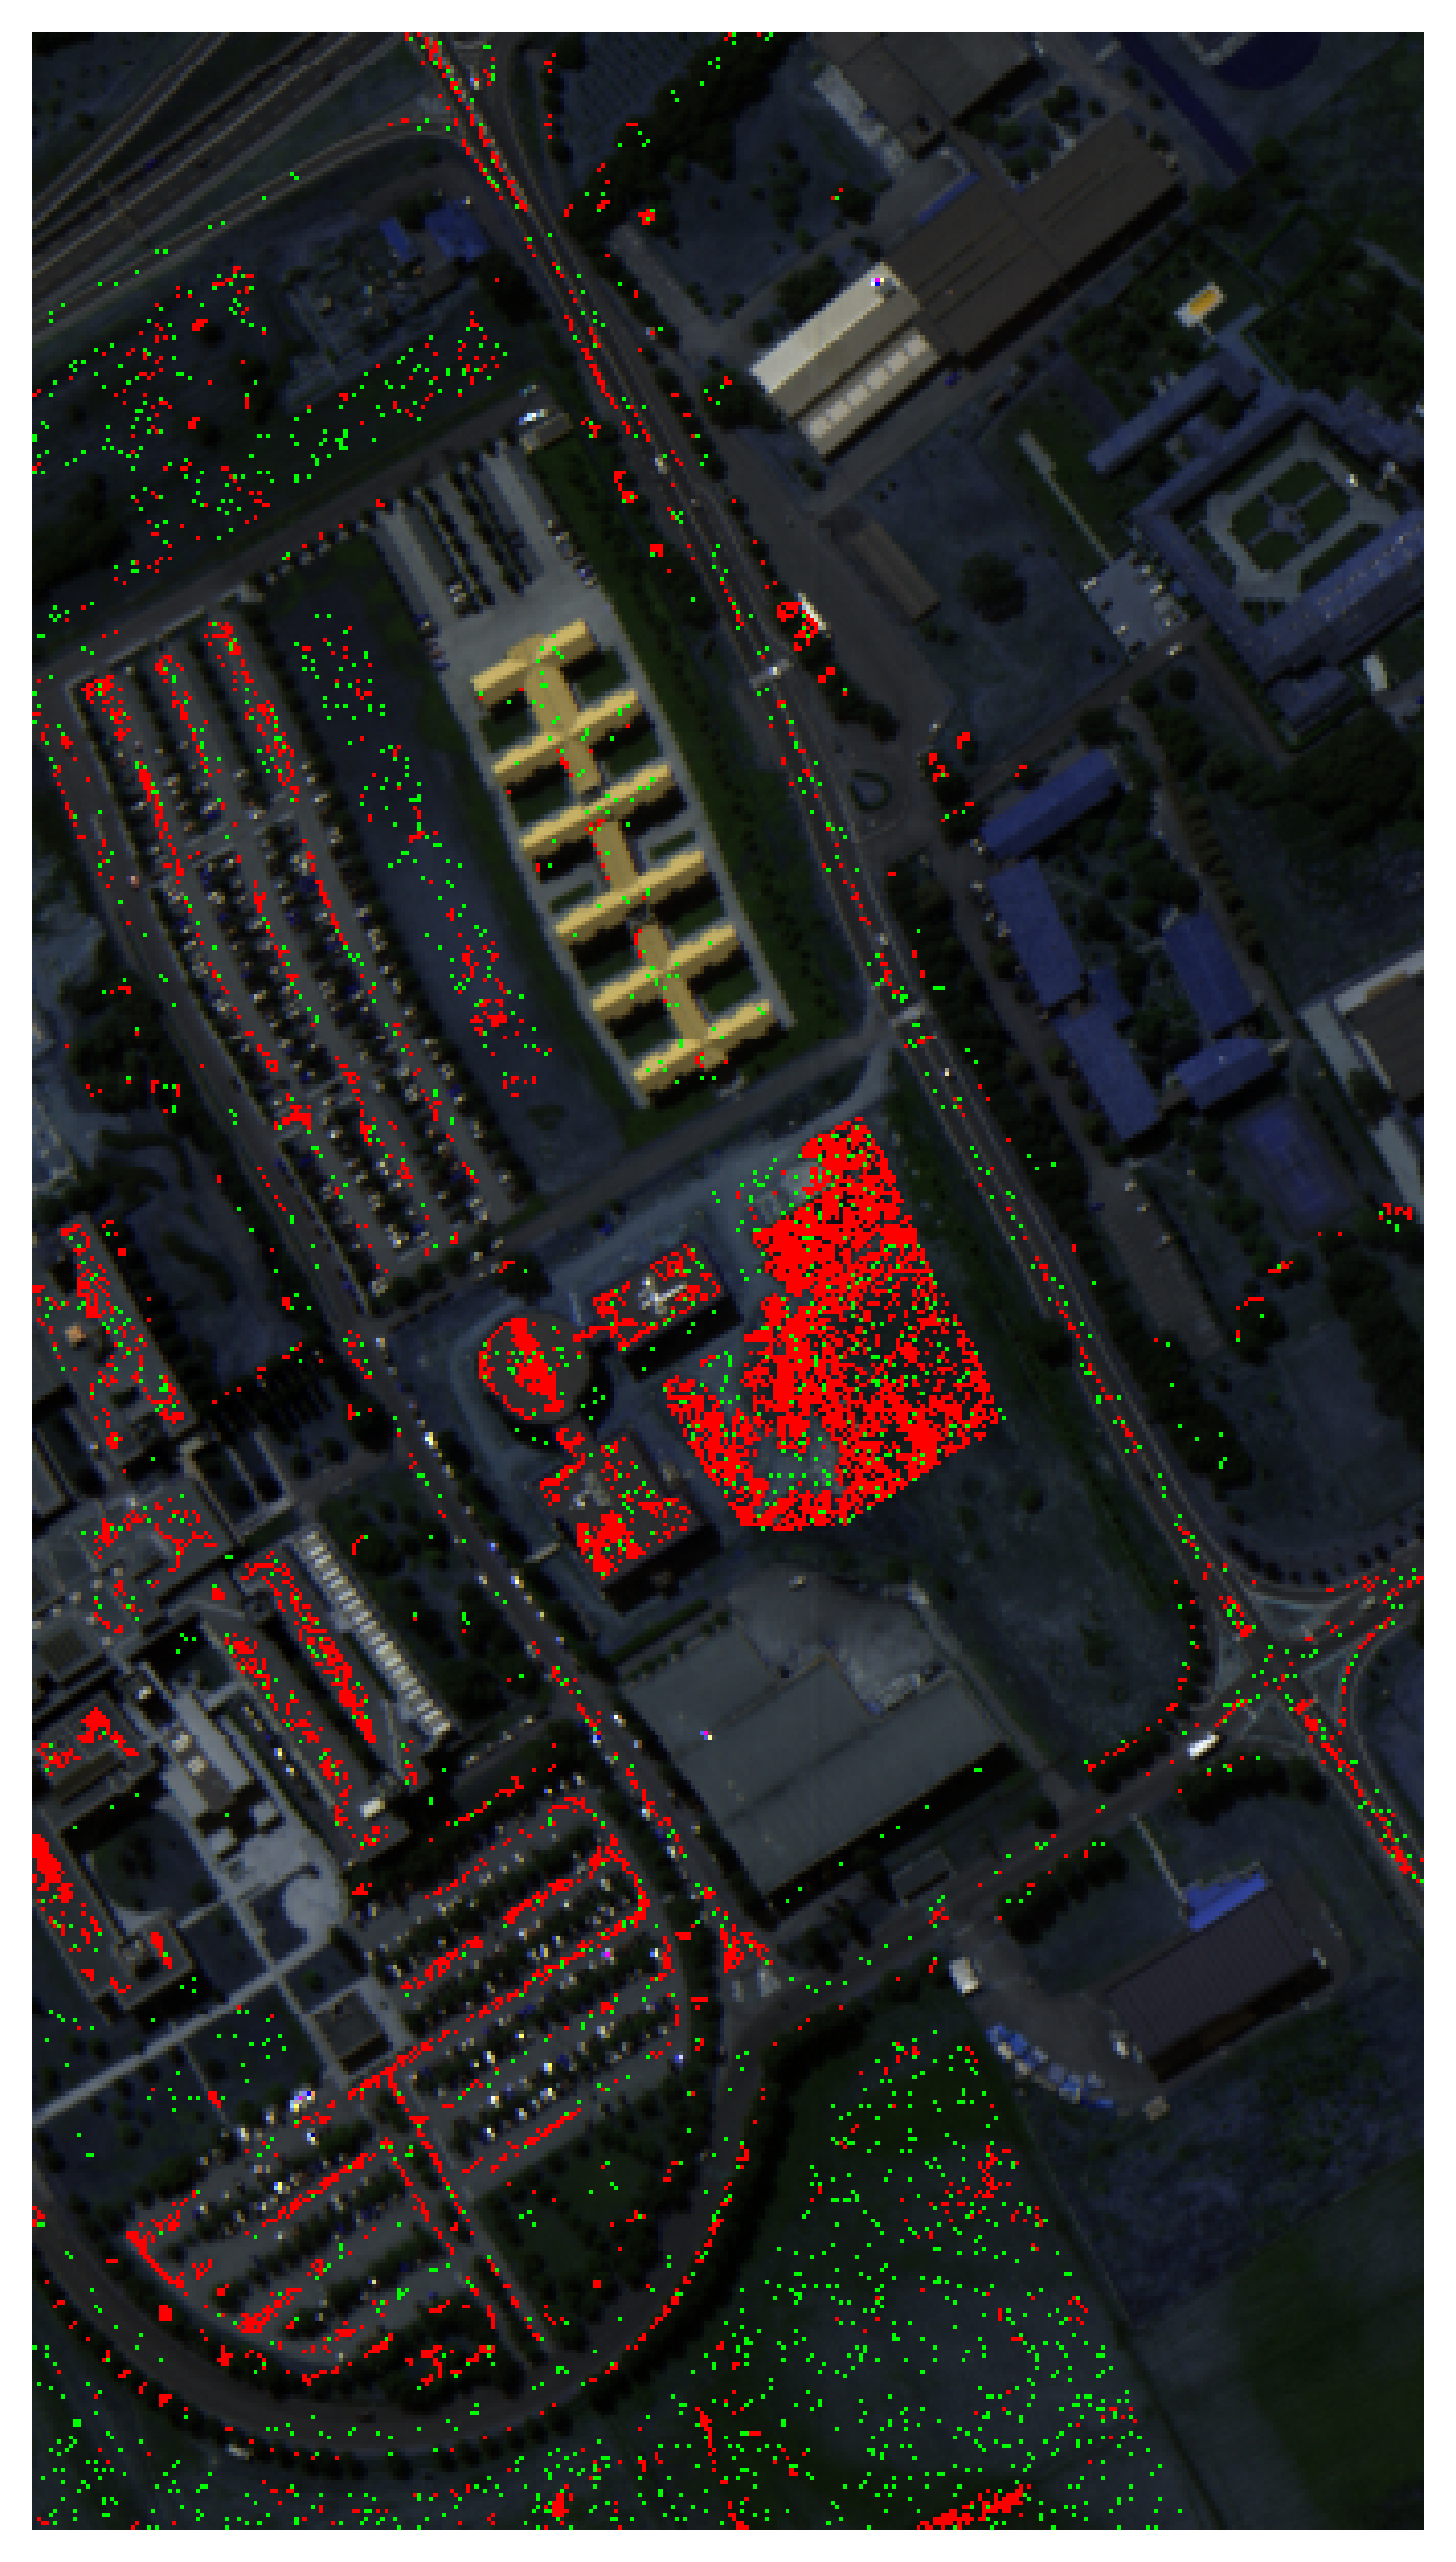

In [2]:
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np


N_ATTRIBUTES = 103
models = ["mi", "vig_ours_rf", "random", "bombs"]
diffs = {}

mmm = "acc;avg_acc;f1_macro;f1_micro;f1_weighted;precision_macro;precision_micro;precision_weighted;recall_macro;recall_micro;recall_weighted;time"
mmm = mmm.split(";")


band_indices = {}
train_indicessssss = {}
for model in models:
    diffs[model] = []

    results = {}
    for metric_name in mmm:
        results[f"{metric_name}"] = {}
    results["time"] = {}

    for n_clusters in list(range(5, N_ATTRIBUTES, 5)):
        dfs = []
        for random_state in range(20):
            df = pd.read_csv(
                f"C:\\Users\\luktu\\Downloads\\gawll (1)\\{model}_pavia_results_test_frac_band_sel_estimators_4\\n_clusters-{n_clusters},test_size-band_sel,random_state-{random_state}.csv"
            ,sep=";")
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True).to_dict(orient="list")
        for k, v in df.items():
            results[k][f"bands_{n_clusters}"] = v

    mae_means = results["f1_weighted"]
    mae_means = {k: np.mean(v) for k, v in mae_means.items()}
    max_element = max(mae_means.items(), key=lambda x: x[1])
    band_index, band_f1 = max_element

    from runner import run

    test_indices, y_pred, train_indices = run(
        select_bands=True,
        n_clusters=int(band_index.replace("bands_", "")),
        n_estimators=4,
        random_state=0,
        model=model
    )

    data = np.load("others/pavia.npy")
    data_re = data.reshape(-1, data.shape[-1])
    num_samples = data_re.shape[0]

    pred = np.empty(shape=(num_samples))
    pred[test_indices] = y_pred

    pred[train_indices] = 0
    pred = pred.reshape((*data.shape[:2],))

    gt = np.load("others/pavia_gt.npy")
    
    diffs[model].append(pred == gt)
    train_indicessssss[model] = train_indices
    band_indices[model] = int(band_index.replace("bands_", ""))

from matplotlib.colors import ListedColormap
data = np.load("others/pavia.npy")
import matplotlib.pyplot as plt
for model in models:
    # cmap = plt.get_cmap('viridis')
    # cmap_colors = cmap(np.arange(cmap.N))
    # cmap_colors[2] = [1, 0, 0, 1]  # RGBA values for white
    # custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors, cmap.N)
    data_sub = data[..., [22, 32, 64]]
    data_sub = (data_sub - data_sub.min()) / (data_sub.max() - data_sub.min())
    data_sub[diffs[model][0] == False] = [1, 0, 0]
    # data_sub[diffs[model][0] == True] = [0, 1, 0]
    data_sub = data_sub.reshape(-1, 3)
    
    data_sub[train_indicessssss[model]] = [0, 1, 0]
    
    data_sub = data_sub.reshape(*data.shape[:2], 3)
    # Create a larger figure with increased DPI
    fig, ax = plt.subplots(figsize=(10, 10), dpi=1000)

    ax.imshow(data_sub)
    ax.set_axis_off()
    # Save the plot without margins
    plt.savefig(f"{model}_class_vis_{band_indices[model]}.pdf", bbox_inches="tight", pad_inches=0)
    plt.show()
    # target_pred__ = (target_pred__ - target_pred__.min()) / (
    #     target_pred__.max() - target_pred__.min()
    # )
    # Display the normalized image
    # img = ax.imshow(diff_to_show, cmap='inferno')
    # ax.scatter(pred_masks[target_index].nonzero()[1], 
    #             pred_masks[target_index].nonzero()[0], c='black', s=0.1,marker='s')
    # # Remove white margins
    # ax.set_axis_off()
    # # fig.colorbar(img, ax=ax)
    # # Save the plot without margins
    # plt.savefig(
    #     f"model_{model}_bands_number_{band_indices[model]}_target_class_{target_index}_diff.pdf",
    #     bbox_inches="tight",
    #     pad_inches=0,
    # )
    # plt.show()

    # plt.close()
